# Watson Analytics - Visual Recognition API

<div class="alert alert-block alert-success">
The IBM Watson Visual Recognition API identifies scenes, objects, and celebrity faces in images uploaded to the service. You can also create and train custom classifiers to identify subjects that suit your need.

More information regarding this API can be found here: <html>https://www.ibm.com/watson/developercloud/visual-recognition/api/v3/?python#introduction</html>

#### Download necessary libraries

In [1]:
!pip install watson-developer-cloud
!pip install opencv-python

#### Import necessary libraries

In [2]:
from watson_developer_cloud import VisualRecognitionV3
import cv2
import matplotlib.pyplot as plt
import json

%matplotlib inline

### plt_show function
The following function will be used to plot images cleanly below.

In [3]:
def plt_show(image, title="", size = (12,10)):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis("off")
    plt.title(title)
    plt.imshow(image, cmap="Greys_r")
    plt.show()

### Insert API credentials from Bluemix
This is found by going the API's page and looking under 'Service Credentials'. The username and password can be viewed by clicking 'View Credentials' next to your Key Name.

**Copy the credentials and replace the contents of *watson_credentials.json*. Alternatively, you can just copy and paste the keys in the variables for username and password.**

#### Parse watson_credentials.json file

In [4]:
credentials = {}

with open('watson_credentials.json') as f:
    data = json.load(f)
    for k in data.keys():
        try:
            credentials[k] = {
                'username': data[k][0]['credentials']['username'],
                'password': data[k][0]['credentials']['password']
            }
        except KeyError:
            credentials[k] = {
                'api_key': data[k][0]['credentials']['api_key']
            }

#### Get username and password for VR
Enter API username and password manually or add to watson credentials file.

In [5]:
key = ''

if key == '':
    key = credentials['watson_vision_combined']['api_key']

## Create Visual Recognition

In [6]:
vr = VisualRecognitionV3(
    '2016-05-20', 
    api_key=key
)

## Image Classification
Watson's visual recognition API is capable of doing image classificiation. By passing it an image, it will run scene classification and provide classes with confidences back to the user.

### classify function
This function can be used to classify any image using IBM Watson. It will parse the json format that visual recognition return to populate a dictionary, and then it will return that dictionary.

In [7]:
def classify(im_path):
    results = {}
    with open(im_path, 'rb') as image_file:
        resp = vr.classify(image_file)
    
    resp = resp['images'][0]['classifiers'][0]['classes']
    
    for cls in resp:
        results[cls['class']] = cls['score']
    
    return results

### Examples
Below are 3 examples using the classify API call. The images are stored in a folder called `images` in the same working directory as this notebook.

For each example image, the image is shown, and then the classes and their corresponding scores are shown below.

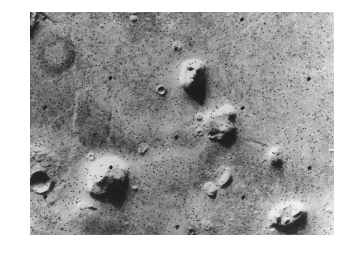

nature (92.4%)
microorganism (79.7%)
gray color (90.5%)
radiogram (50.0%)
autoradiograph (50.0%)
lunar crater (92.4%)
black color (91.1%)


In [8]:
plt_show(cv2.imread('images/myimage.jpg'))
results = classify('images/myimage.jpg')

for k,v in results.items():
    print ("{} ({}%)".format(k, round(v*100,2)))

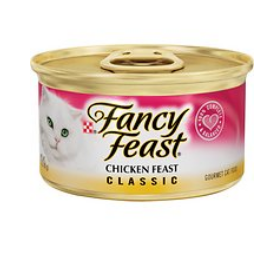

cat food (78.9%)
pale yellow color (92.5%)
feed (78.9%)
formula (57.3%)
canned food (65.2%)
memory device (50.0%)
face pack (52.2%)
food product (78.9%)
milk (57.3%)
CD-R (50.0%)
toiletry (79.2%)
food (92.7%)


In [9]:
plt_show(cv2.imread('images/catfood.jpg'))
results = classify('images/catfood.jpg')

for k,v in results.items():
    print ("{} ({}%)".format(k, round(v*100,2)))

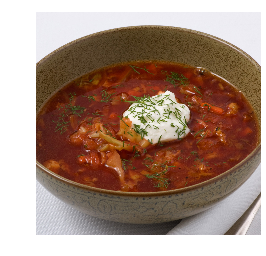

borsch (75.8%)
soup (94.4%)
nutrition (95.9%)
dish (95.9%)
petite marmite (68.8%)
goulash (50.0%)
reddish orange color (81.7%)
gumbo (52.5%)
food (95.9%)
Indian red color (92.1%)
gazpacho (58.6%)
stew (50.6%)


In [10]:
plt_show(cv2.imread('images/br1.jpg'))
results = classify('images/br1.jpg')

for k,v in results.items():
    print ("{} ({}%)".format(k, round(v*100,2)))

## Detect Faces
Watson also have a face detector API call. It can detect the locations of faces in images uploaded to their service. Watson also may be able to predict the age, name, and gender of the person that they detect.

### detectFaces function
This function can be used to detect faces in any image using IBM Watson. It will parse the json format that visual recognition returns to populate a dictionary, and then it will return that dictionary. There is also an optional argument to draw faces as well.

In [11]:
def detectFaces(im_path, draw=True):
    people = []
    with open(im_path, 'rb') as image_file:
        resp = vr.detect_faces(image_file)
    
    faces = resp['images'][0]['faces']
    
    for face in faces:
        print (face)
        person = {}
        
        # Get gender if available
        try:
            person['gender'] = face['gender']
        except KeyError:
            person['gender'] = {
                'gender': 'Unknown',
                'score': 0.0
            }
            
        # Get age if available 
        try:
            person['age'] = {
                'age': face['age']['min'],
                'score': face['age']['score']   
            }
        except KeyError:
            person['age'] = {
                'age': 0.0,
                'score': 0.0
            }
            
        # Get name if available
        try:
            person['name'] = {
                'name': face['identity']['name'],
                'score': face['identity']['score']   
            }
        except KeyError:
            person['name'] = {
                'name': "Unknown",
                'score': 0.0
            }
            
        person['loc'] = {
            'l': face['face_location']['left'],
            't': face['face_location']['top'],
            'w': face['face_location']['width'],
            'h': face['face_location']['height']
            
        }        
        people.append(person)
        
    if draw:
        im = cv2.imread(im_path)
        font = cv2.FONT_HERSHEY_DUPLEX
        
        for person in people:
            
            # Draw bounding box for face
            x = person['loc']['l']
            y = person['loc']['t']
            w = person['loc']['w']
            h = person['loc']['h']           
            cv2.rectangle(im, (x,y), (x+w, y+h), (0,255,0), 3)
            
            offset = 0
            
            for typ in ['gender','age','name']:
                offset -= 30
                cls = person[typ][typ]
                conf = round(person[typ]['score']*100.0,2)
                text = "{} ({}%)".format(cls,conf)
                cv2.putText(im, text, (x, y + offset), font, 0.8, (0,255,0), 2)
                
        plt_show(im)
                        
    return people

### Examples
Below are 3 examples using the detect_faces API call. The images are stored in a folder called `images` in the same working directory as this notebook.

{'face_location': {'width': 133, 'left': 520, 'height': 107, 'top': 145}, 'gender': {'gender': 'MALE', 'score': 0.982014}, 'age': {'score': 0.670626, 'min': 65}}
{'face_location': {'width': 100, 'left': 209, 'height': 98, 'top': 124}, 'identity': {'type_hierarchy': '/people/justin trudeau', 'name': 'Justin Trudeau', 'score': 0.817574}, 'gender': {'gender': 'MALE', 'score': 0.99593}, 'age': {'score': 0.403753, 'min': 35, 'max': 44}}


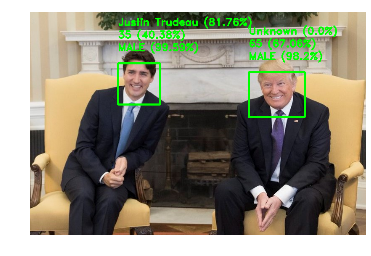

In [12]:
people = detectFaces('images/trumptrudeau.jpg', draw=True)

{'face_location': {'width': 163, 'left': 331, 'height': 164, 'top': 113}, 'gender': {'gender': 'MALE', 'score': 0.182426}, 'age': {'score': 0.403753, 'min': 35, 'max': 44}}


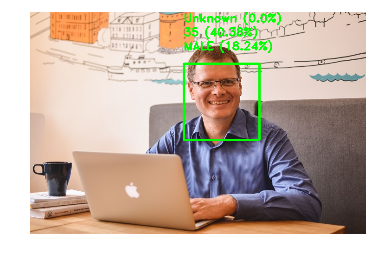

In [13]:
people = detectFaces('images/webcam.jpg', draw=True)

#### Check out the model on the Watson Visual Recognition Tool
> [Watson Visual Recognition Tool](https://cocl.us/watsonvrtool) (GUI interface)

### For more tutorials on Watson Visual Recognition:
- [Watson Visual Recognition](https://cocl.us/watsonvr)
- [Watson Visual Recognition Full Documentation](https://cocl.us/A9SOS)
- [Watson Visual Recognition Tool](https://cocl.us/watsonvrtool) (GUI interface)
- [Watson tagging videos](https://cocl.us/darkvision)
- [Tutorial: Create a robot using Raspberry Pi that you can talk to and that can recognize your face](https://cocl.us/tjbot)
- [Tile Localization technique / code](https://github.com/IBM-Bluemix/Visual-Recognition-Tile-Localization)
- [Using Watson Visual Recognition to detect seafood fraud](https://devpost.com/software/dory)
